In [1]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import scipy.stats as ss
from scipy.optimize import curve_fit
from scipy.stats import norm
from ntuple_lib import *
beautify_plots(plt)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib as mpl
plt.rcParams["figure.figsize"] = (12, 8)

In [2]:
def computeLocalPUDensity(all_events_vertex_zs, delta_z):
    localPUdensity = []
    for vertex_zs in all_events_vertex_zs:
        localPUdensity.append((np.sum(np.abs(vertex_zs[0]-vertex_zs[1:]) < delta_z))/(2*delta_z))
    return localPUdensity
def computeAvgPUDensity(all_events_vertex_zs, mu=200, sigma_z=50):
    avgPUdensity = []
    for vertex_zs in all_events_vertex_zs:
        avgPUdensity.append(mu/(sigma_z*np.sqrt(2*np.pi)) * np.exp(-0.5*vertex_zs[0]**2/sigma_z**2))
    return avgPUdensity

In [3]:
# files = ['ntuples_condor/OutDir_{}/hist-Rel21sample.root'.format(i) for i in range(1, 10)]
files = ['../ntuples/ttbar/hist-Rel21sample.root']
track_t = np.array([], dtype='object')
track_t30 = np.array([], dtype='object')
track_t90 = np.array([], dtype='object')
track_t180 = np.array([], dtype='object')

reco_vertex_track_idxs = np.array([], dtype='object')
reco_vertex_track_weights = np.array([], dtype='object')
truth_vertex_track_idxs = np.array([], dtype='object')

reco_vertex_sumPt2 = np.array([], dtype='object')

reco_vertex_z = np.array([], dtype='object')
truth_vertex_z = np.array([], dtype='object')
truth_vertex_t = np.array([], dtype='object')

for file in files:
    root_file = uproot.open(file)
    for key in root_file.keys():
        if key.startswith('EventTree'):
            tree = root_file[key]
            track_t = np.concatenate((track_t, tree['track_t'].array(library='np')))
            track_t30 = np.concatenate((track_t30, tree['track_t30'].array(library='np')))
            track_t90 = np.concatenate((track_t90, tree['track_t90'].array(library='np')))
            track_t180 = np.concatenate((track_t180, tree['track_t180'].array(library='np')))
            
            reco_vertex_track_idxs = np.concatenate((reco_vertex_track_idxs, tree['recovertex_tracks_idx'].array(library='np')))
            reco_vertex_track_weights = np.concatenate((reco_vertex_track_weights, tree['recovertex_tracks_weight'].array(library='np')))
            truth_vertex_track_idxs = np.concatenate((truth_vertex_track_idxs, tree['truthvertex_tracks_idx'].array(library='np')))
            
            reco_vertex_sumPt2 = np.concatenate((reco_vertex_sumPt2, tree['recovertex_sumPt2'].array(library='np')))
            
            reco_vertex_z = np.concatenate((reco_vertex_z, tree['recovertex_z'].array(library='np')))
            truth_vertex_z = np.concatenate((truth_vertex_z, tree['truthvertex_z'].array(library='np')))
            truth_vertex_t = np.concatenate((truth_vertex_t, tree['truthvertex_t'].array(library='np')))

In [4]:
## Find truth link via number of shared tracks
recoHS_to_truth_link_idx = []
truthHS_to_reco_link_idx = []
for event_idx in range(len(truth_vertex_t)):
    event_reco_to_truth_n_tracks = -1
    event_reco_to_truth_idx = -1
    reco_hs_track_idx = reco_vertex_track_idxs[event_idx][0]
    for i, truth_track_idxs in enumerate(truth_vertex_track_idxs[event_idx]):
        n = len(np.intersect1d(reco_hs_track_idx, truth_track_idxs))
        if n > event_reco_to_truth_n_tracks and i < 100:
            # print(event_idx, n)
            event_reco_to_truth_n_tracks = n
            event_reco_to_truth_idx = i
    
    event_truth_to_reco_n_tracks = -1
    event_truth_to_reco_idx = -1
    truth_hs_track_idx = truth_vertex_track_idxs[event_idx][0]
    for i, reco_track_idxs in enumerate(reco_vertex_track_idxs[event_idx]):
        n = len(np.intersect1d(truth_hs_track_idx, reco_track_idxs))
        if n > event_truth_to_reco_n_tracks and i < 100:
            # print(event_idx, n)
            event_truth_to_reco_n_tracks = n
            event_truth_to_reco_idx = i
    
    recoHS_to_truth_link_idx.append(event_reco_to_truth_idx)
    truthHS_to_reco_link_idx.append(event_truth_to_reco_idx)
recoHS_to_truth_link_idx = np.array(recoHS_to_truth_link_idx)
truthHS_to_reco_link_idx = np.array(truthHS_to_reco_link_idx)

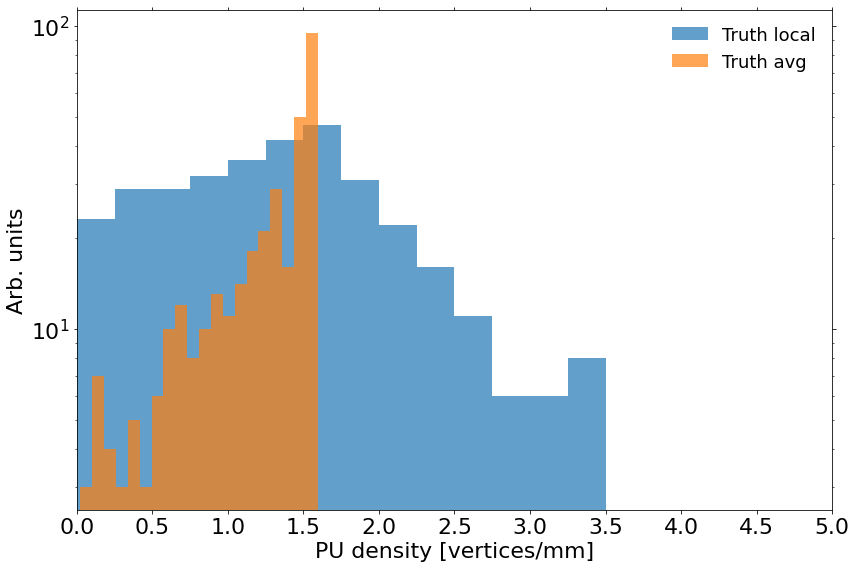

In [69]:
delta_z = 2
truth_localPU = computeLocalPUDensity(truth_vertex_z, delta_z)
reco_localPU = computeLocalPUDensity(reco_vertex_z,   delta_z)

truth_avgPU = computeAvgPUDensity(truth_vertex_z)
reco_avgPU = computeAvgPUDensity(reco_vertex_z)

binwidth = 1/(2*delta_z)

_, truth_bin_edges, _ = plt.hist(truth_localPU, bins=np.arange(np.min(truth_localPU), np.max(truth_localPU) + binwidth, binwidth), density=False, alpha=0.7, label='Truth local')
# _, reco_bin_edges, _  = plt.hist(reco_localPU,  bins=np.arange(np.min(reco_localPU), np.max(reco_localPU) + binwidth, binwidth), density=False, alpha=0.7, label='Reco local')

_, truth_avg_bin_edges, _ = plt.hist(truth_avgPU, bins=20, density=False, alpha=0.7, label='Truth avg')
# _, reco_avg_bin_edges, _  = plt.hist(reco_avgPU,  bins=np.arange(np.min(reco_localPU), np.max(reco_localPU) + binwidth, binwidth), density=False, alpha=0.7, label='Reco avg')

# plt.text(0.1, 1900, 'Local PU $\\Delta z = {}$ mm'.format(delta_z), fontsize=22)

plt.xlabel('PU density [vertices/mm]')
plt.ylabel('Arb. units')
plt.yscale('log')
plt.xticks(np.arange(0, 10, 0.5))
plt.xlim(0, 5)
plt.legend(frameon=False)
plt.tight_layout()

In [58]:
def vtx_time_info(events_in_PU_bins, truth_vtx_idx_in_PU_bins, all_truth_vtx_t, reco_vtx_idx_in_PU_bins, all_reco_track_idxs, all_reco_track_weights, all_track_t, sigma_cut, weight_cut):
    track_delta_t = []
    track_delta_t_rms = []
    
    track_weight_cut_delta_t = []
    track_weight_cut_delta_t_rms = []
    
    track_vtx_t_res = []
    track_vtx_t_res_weight_cut = []
    track_vtx_t_res_sigma_cut = []
    
    vtx_delta_t = []
    vtx_weighted_delta_t = []
    vtx_weight_cut_delta_t = []
    
    vtx_t_res = []
    vtx_weighted_t_res = []
    vtx_weight_cut_t_res = []
    vtx_weight_cut_weighted_t_res = []
    vtx_sigma_cut_weighted_t_res = []

    avg_n_tracks = []
    avg_n_tracks_weight_cut = []
    avg_n_tracks_sigma_cut = []

    for event_idxs, truth_vtx_idxs, reco_vtx_idxs in zip(events_in_PU_bins, truth_vtx_idx_in_PU_bins, reco_vtx_idx_in_PU_bins):
        bin_track_delta_t = np.array([])
        bin_track_delta_t_rms = []
        
        bin_vtx_delta_t = []
        bin_vtx_weighted_delta_t = []
        
        bin_track_weight_cut_delta_t = np.array([])
        bin_track_weight_cut_delta_t_rms = []
        
        bin_vtx_weight_cut_delta_t = []
        bin_vtx_weight_cut_weighted_delta_t = []
        
        bin_reco_n_tracks = []
        bin_reco_n_tracks_weight_cut = []
        for idx, truth_idx, reco_idx in zip(event_idxs, truth_vtx_idxs, reco_vtx_idxs):
            idx = idx[0]
            reco_track_t = all_track_t[idx][all_reco_track_idxs[idx][reco_idx]]
            reco_track_t_clean_idx = np.logical_and(reco_track_t != -1e3, reco_track_t != -1e6)
            reco_track_t = reco_track_t[np.logical_and(reco_track_t != -1e3, reco_track_t != -1e6)]
            reco_track_weights = all_reco_track_weights[idx][reco_idx][reco_track_t_clean_idx]
            bin_reco_n_tracks.append(len(reco_track_t))
            
            truth_t = all_truth_vtx_t[idx][truth_idx]
            event_track_delta_t = reco_track_t - truth_t
            
            bin_track_delta_t = np.concatenate((bin_track_delta_t, event_track_delta_t))
            bin_track_delta_t_rms.append(np.sqrt(np.mean(event_track_delta_t**2)))
            
            reco_vtx_t = np.mean(reco_track_t)
            reco_vtx_weighted_t = np.average(reco_track_t, weights=reco_track_weights)
            
            bin_vtx_delta_t.append(reco_vtx_t - truth_t)
            bin_vtx_weighted_delta_t.append(reco_vtx_weighted_t - truth_t)
            
            # Weight cut
            weight_cut_idx = np.array(reco_track_weights) > weight_cut
            weight_cut_track_t = reco_track_t[weight_cut_idx]
            bin_reco_n_tracks_weight_cut.append(len(weight_cut_track_t))
            
            weight_cut_event_delta_t = weight_cut_track_t - truth_t
        
            bin_track_weight_cut_delta_t = np.concatenate((bin_track_weight_cut_delta_t, weight_cut_event_delta_t))
            bin_track_weight_cut_delta_t_rms.append(np.sqrt(np.mean(weight_cut_event_delta_t**2)))
            
            weight_cut_vtx_t = np.mean(weight_cut_track_t)
            weight_cut_vtx_weighted_t = np.average(weight_cut_track_t, weights = reco_track_weights[weight_cut_idx])
            
            bin_vtx_weight_cut_delta_t.append(weight_cut_vtx_t - truth_t)
            bin_vtx_weight_cut_weighted_delta_t.append(weight_cut_vtx_weighted_t - truth_t)
        
        avg_n_tracks.append(np.mean(bin_reco_n_tracks))
        avg_n_tracks_weight_cut.append(np.mean(bin_reco_n_tracks_weight_cut))
        
        track_delta_t.append(bin_track_delta_t)
        track_delta_t_rms.append(bin_track_delta_t_rms)
        track_weight_cut_delta_t.append(bin_track_weight_cut_delta_t)
        track_weight_cut_delta_t_rms.append(bin_track_weight_cut_delta_t_rms)
        track_vtx_t_res.append(np.mean(bin_track_delta_t_rms / np.sqrt(np.array(bin_reco_n_tracks))))
        track_vtx_t_res_weight_cut.append(np.mean(bin_track_weight_cut_delta_t_rms / np.sqrt(np.array(bin_reco_n_tracks_weight_cut))))
        
        
        vtx_delta_t.append(bin_vtx_delta_t)
        vtx_weighted_delta_t.append(bin_vtx_weighted_delta_t)
        vtx_weight_cut_delta_t.append(bin_vtx_weight_cut_delta_t)
        
        vtx_t_res.append(np.sqrt(np.mean(np.array(bin_vtx_delta_t)**2)))
        vtx_weighted_t_res.append(np.sqrt(np.mean(np.array(bin_vtx_weighted_delta_t)**2)))
        vtx_weight_cut_t_res.append(np.sqrt(np.mean(np.array(bin_vtx_weight_cut_delta_t)**2)))
        vtx_weight_cut_weighted_t_res.append(np.sqrt(np.mean(np.array(bin_vtx_weight_cut_weighted_delta_t)**2)))
        
        bin_vtx_weighted_delta_t_sigma = np.std(bin_vtx_weighted_delta_t, ddof=1)
        bin_vtx_delta_t_sigma_cut_idxs = np.abs(bin_vtx_weighted_delta_t - np.mean(bin_vtx_weighted_delta_t)) < sigma_cut*bin_vtx_weighted_delta_t_sigma
        vtx_sigma_cut_weighted_t_res.append(np.sqrt(np.mean(np.array(bin_vtx_weight_cut_weighted_delta_t)[bin_vtx_delta_t_sigma_cut_idxs]**2)))
        
    return  avg_n_tracks, \
            track_delta_t, \
            track_delta_t_rms, \
            track_weight_cut_delta_t, \
            track_weight_cut_delta_t_rms, \
            track_vtx_t_res, \
            track_vtx_t_res_weight_cut, \
            vtx_delta_t, \
            vtx_weight_cut_delta_t, \
            vtx_t_res, \
            vtx_weighted_t_res, \
            vtx_weight_cut_t_res, \
            vtx_weight_cut_weighted_t_res, \
            vtx_sigma_cut_weighted_t_res

def closest_truth_vtx_time_info(events_in_PU_bins, all_truth_vtx_z, all_truth_vtx_t, all_reco_track_idxs, all_reco_track_weights, all_reco_vtx_z, all_track_t, sigma_cut, weight_cut):
    reco_vtx_idx_in_PU_bins = [[0 for idx in event_idx] for event_idx in events_in_PU_bins]
    truth_vtx_idx_in_PU_bins = [[np.argmin(np.abs(truth_vertex_z[idx[0]] - reco_vertex_z[idx[0]][0])) for idx in event_idx] for event_idx in events_in_PU_bins]
    return vtx_time_info(events_in_PU_bins, truth_vtx_idx_in_PU_bins, all_truth_vtx_t, reco_vtx_idx_in_PU_bins, all_reco_track_idxs, all_reco_track_weights, all_track_t, sigma_cut, weight_cut)

def truth_to_reco_link_vtx_time_info(events_in_PU_bins, all_truthHS_to_reco_idx, all_truth_vtx_t, all_reco_track_idxs, all_reco_track_weights, all_track_t, sigma_cut, weight_cut):
    truth_vtx_idx_in_PU_bins = [[0 for idx in event_idx] for event_idx in events_in_PU_bins]
    reco_vtx_idx_in_PU_bins = [[all_truthHS_to_reco_idx[idx[0]] for idx in event_idx] for event_idx in events_in_PU_bins]
    
    return vtx_time_info(events_in_PU_bins, truth_vtx_idx_in_PU_bins, all_truth_vtx_t, reco_vtx_idx_in_PU_bins, all_reco_track_idxs, all_reco_track_weights, all_track_t, sigma_cut, weight_cut)
    

## TODO: write function to load root files into ram when needed instead of all at once 
    

        # bin_sigma = np.std(bin_closest_truth_delta_t)
        # bin_closest_truth_t30_diff_std_of_mean_sigma_cut = []
        # reco_n_tracks_events_cut = []
        # for idx in event_idxs:
        #     diff_t30_sigma_cut = diff_t30[np.abs(diff_t30 - np.mean(diff_t30)) < sigma_cut*bin_sigma]
        #     reco_n_tracks_events_cut.append(len(diff_t30_sigma_cut))
        #     bin_closest_truth_t30_diff_std_of_mean_sigma_cut.append(np.std(diff_t30_sigma_cut)/np.sqrt(len(diff_t30_sigma_cut)))
        # closest_truth_vtx_t30_res_sigma_cut.append(np.mean(bin_closest_truth_t30_diff_std_of_mean_sigma_cut))
        # avg_n_tracks30_sigma_cut.append(np.mean(reco_n_tracks_events_cut))

In [59]:
events_in_PU_bins = []
for bin in truth_bin_edges:
    events_in_PU_bins.append(np.argwhere(np.isclose(truth_localPU, bin)))

link_avg_n_tracks30, \
link_track_delta_t30, \
link_track_delta_t30_rms, \
link_track_weight_cut_delta_t30, \
link_track_weight_cut_delta_t30_rms, \
link_track_vtx_t30_res, \
link_track_vtx_t30_res_weight_cut, \
link_vtx_delta_t30, \
link_vtx_weight_cut_delta_t30, \
link_vtx_t30_res, \
link_vtx_weighted_t30_res, \
link_vtx_weight_cut_t30_res, \
link_vtx_weight_cut_weighted_t30_res, \
link_vtx_sigma_cut_weighted_t30_res = truth_to_reco_link_vtx_time_info(events_in_PU_bins, truthHS_to_reco_link_idx, truth_vertex_t, reco_vertex_track_idxs, \
                                                                reco_vertex_track_weights, track_t30, 2, 0.9)

link_avg_n_tracks90, \
link_track_delta_t90, \
link_track_delta_t90_rms, \
link_track_weight_cut_delta_t90, \
link_track_weight_cut_delta_t90_rms, \
link_track_vtx_t90_res, \
link_track_vtx_t90_res_weight_cut, \
link_vtx_delta_t90, \
link_vtx_weight_cut_delta_t90, \
link_vtx_t90_res, \
link_vtx_weighted_t90_res, \
link_vtx_weight_cut_t90_res, \
link_vtx_weight_cut_weighted_t90_res, \
link_vtx_sigma_cut_weighted_t90_res = truth_to_reco_link_vtx_time_info(events_in_PU_bins, truthHS_to_reco_link_idx, truth_vertex_t, reco_vertex_track_idxs, \
                                                                reco_vertex_track_weights, track_t90, 2, 0.9)

link_avg_n_tracks180, \
link_track_delta_t180, \
link_track_delta_t180_rms, \
link_track_weight_cut_delta_t180, \
link_track_weight_cut_delta_t180_rms, \
link_track_vtx_t180_res, \
link_track_vtx_t180_res_weight_cut, \
link_vtx_delta_t180, \
link_vtx_weight_cut_delta_t180, \
link_vtx_t180_res, \
link_vtx_weighted_t180_res, \
link_vtx_weight_cut_t180_res, \
link_vtx_weight_cut_weighted_t180_res, \
link_vtx_sigma_cut_weighted_t180_res = truth_to_reco_link_vtx_time_info(events_in_PU_bins, truthHS_to_reco_link_idx, truth_vertex_t, reco_vertex_track_idxs, \
                                                                reco_vertex_track_weights, track_t180, 2, 0.9)

In [60]:
events_in_PU_bins = []
for bin in truth_bin_edges:
    events_in_PU_bins.append(np.argwhere(np.isclose(truth_localPU, bin)))

avg_n_tracks, \
track_delta_t, \
track_delta_t_rms, \
track_weight_cut_delta_t, \
track_weight_cut_delta_t_rms, \
track_vtx_t_res, \
track_vtx_t_res_weight_cut, \
vtx_delta_t, \
vtx_weight_cut_delta_t, \
vtx_t_res, \
vtx_weighted_t_res, \
vtx_weight_cut_t_res, \
vtx_weight_cut_weighted_t_res,\
vtx_sigma_cut_weighted_t_res = closest_truth_vtx_time_info(events_in_PU_bins, truth_vertex_z, truth_vertex_t, reco_vertex_track_idxs, \
                                                                reco_vertex_track_weights, reco_vertex_z, track_t, 2, 0.9)
avg_n_tracks30, \
track_delta_t30, \
track_delta_t30_rms, \
track_weight_cut_delta_t30, \
track_weight_cut_delta_t30_rms, \
track_vtx_t30_res, \
track_vtx_t30_res_weight_cut, \
vtx_delta_t30, \
vtx_weight_cut_delta_t30, \
vtx_t30_res, \
vtx_weighted_t30_res, \
vtx_weight_cut_t30_res, \
vtx_weight_cut_weighted_t30_res, \
vtx_sigma_cut_weighted_t30_res = closest_truth_vtx_time_info(events_in_PU_bins, truth_vertex_z, truth_vertex_t, reco_vertex_track_idxs, \
                                                                reco_vertex_track_weights, reco_vertex_z, track_t30, 2, 0.9)

avg_n_tracks90, \
track_delta_t90, \
track_delta_t90_rms, \
track_weight_cut_delta_t90, \
track_weight_cut_delta_t90_rms, \
track_vtx_t90_res, \
track_vtx_t90_res_weight_cut, \
vtx_delta_t90, \
vtx_weight_cut_delta_t90, \
vtx_t90_res, \
vtx_weighted_t90_res, \
vtx_weight_cut_t90_res, \
vtx_weight_cut_weighted_t90_res, \
vtx_sigma_cut_weighted_t90_res = closest_truth_vtx_time_info(events_in_PU_bins, truth_vertex_z, truth_vertex_t, reco_vertex_track_idxs, \
                                                                reco_vertex_track_weights, reco_vertex_z, track_t90, 2, 0.9)
                                                                
avg_n_tracks180, \
track_delta_t180, \
track_delta_t180_rms, \
track_weight_cut_delta_t180, \
track_weight_cut_delta_t180_rms, \
track_vtx_t180_res, \
track_vtx_t180_res_weight_cut, \
vtx_delta_t180, \
vtx_weight_cut_delta_t180, \
vtx_t180_res, \
vtx_weighted_t180_res, \
vtx_weight_cut_t180_res, \
vtx_weight_cut_weighted_t180_res, \
vtx_sigma_cut_weighted_t180_res = closest_truth_vtx_time_info(events_in_PU_bins, truth_vertex_z, truth_vertex_t, reco_vertex_track_idxs, \
                                                                reco_vertex_track_weights, reco_vertex_z, track_t180, 2, 0.9)


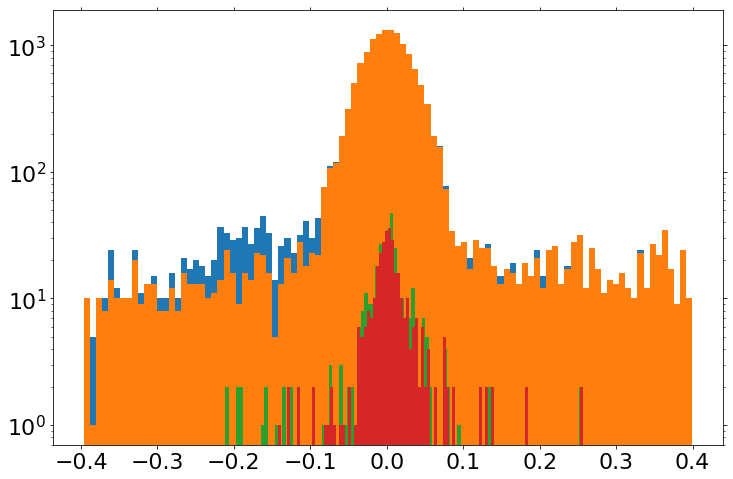

In [72]:
max_t = 0.4

plt.hist(np.concatenate(track_delta_t30)[np.abs(np.concatenate(track_delta_t30)) < max_t], bins = 100)
plt.hist(np.concatenate(link_track_delta_t30)[np.abs(np.concatenate(link_track_delta_t30)) < max_t], bins = 100)
plt.hist(np.concatenate(vtx_delta_t30)  [np.abs(np.concatenate(vtx_delta_t30)) < max_t]  , bins = 100)
plt.hist(np.concatenate(link_vtx_delta_t30)  [np.abs(np.concatenate(link_vtx_delta_t30)) < max_t]  , bins = 100)

plt.yscale('log')

In [40]:
bootstrapped_vtx_res = []
bootstrapped_vtx_res_std = []
for i in range(len(events_in_PU_bins)):
    bin_vtx_res = []
    for _ in range(1000):
        idx = np.random.randint(0, len(vtx_delta_t30[i]), len(vtx_delta_t30[i]))
        bin_vtx_res.append(np.sqrt(np.mean(np.array(vtx_delta_t30[i])[idx]**2)))
    bootstrapped_vtx_res.append(np.mean(bin_vtx_res))
    bootstrapped_vtx_res_std.append(np.std(bin_vtx_res))

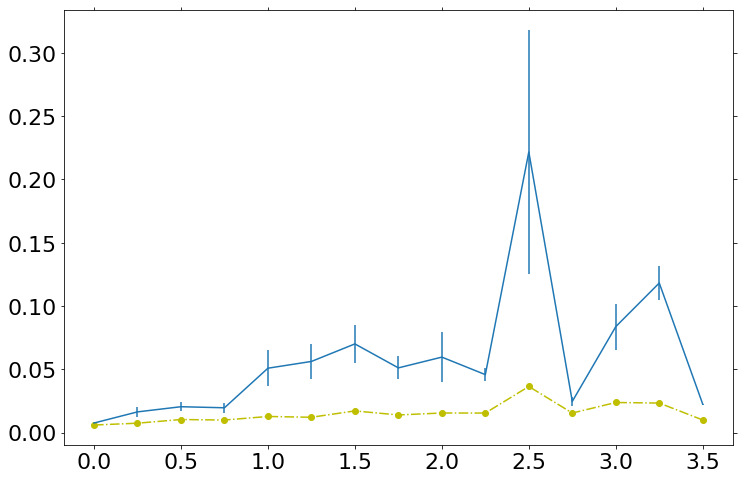

In [41]:
plt.errorbar(truth_bin_edges, bootstrapped_vtx_res, bootstrapped_vtx_res_std)
plt.plot(truth_bin_edges, np.array(track_vtx_t30_res), 'yo-.', label='Vtx resolution from tracks')


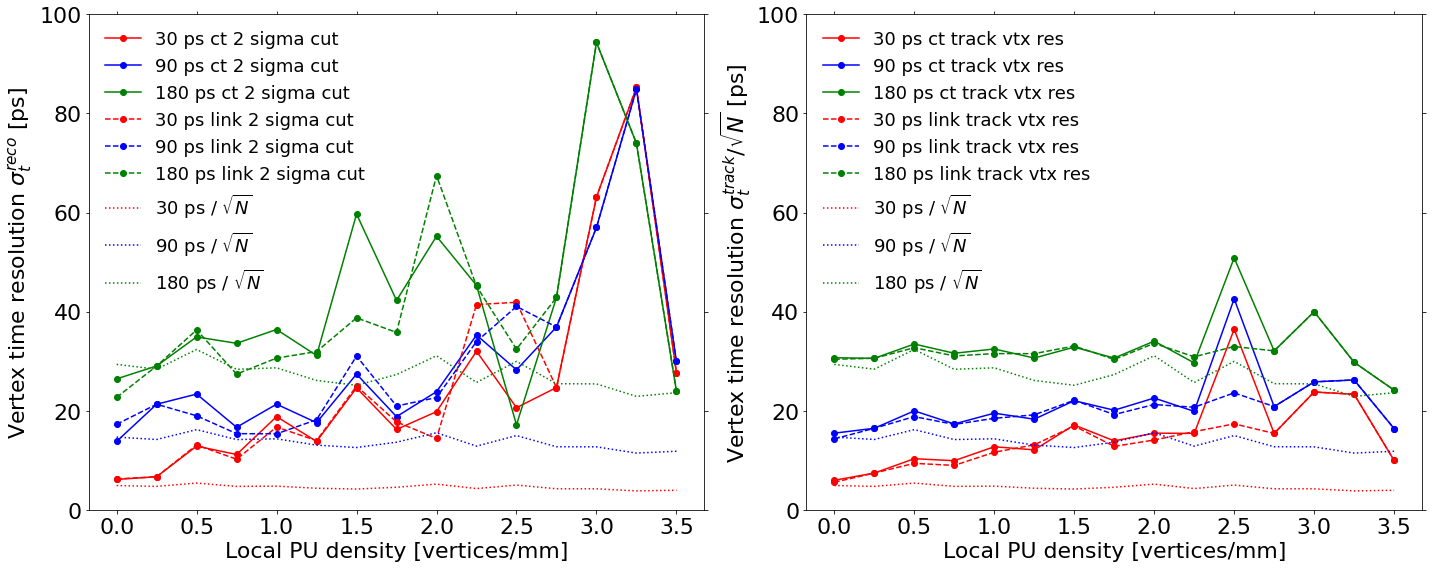

In [67]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 8)


ax1.plot(truth_bin_edges, 1e3*np.array(vtx_sigma_cut_weighted_t30_res), 'ro-', label='30 ps ct {} sigma cut'.format(2))
ax1.plot(truth_bin_edges, 1e3*np.array(vtx_sigma_cut_weighted_t90_res), 'bo-', label='90 ps ct {} sigma cut'.format(2))
ax1.plot(truth_bin_edges, 1e3*np.array(vtx_sigma_cut_weighted_t180_res), 'go-', label='180 ps ct {} sigma cut'.format(2))
ax1.plot(truth_bin_edges, 1e3*np.array(link_vtx_sigma_cut_weighted_t30_res), 'ro--', label='30 ps link {} sigma cut'.format(2))
ax1.plot(truth_bin_edges, 1e3*np.array(link_vtx_sigma_cut_weighted_t90_res), 'bo--', label='90 ps link {} sigma cut'.format(2))
ax1.plot(truth_bin_edges, 1e3*np.array(link_vtx_sigma_cut_weighted_t180_res), 'go--', label='180 ps link {} sigma cut'.format(2))

ax1.plot(truth_bin_edges, 30/np.sqrt(avg_n_tracks30), 'r:', label='30 ps / $\\sqrt{N}$')
ax1.plot(truth_bin_edges, 90/np.sqrt(avg_n_tracks90), 'b:', label='90 ps / $\\sqrt{N}$')
ax1.plot(truth_bin_edges, 180/np.sqrt(avg_n_tracks180), 'g:', label='180 ps / $\\sqrt{N}$')

ax1.legend(frameon=False)
ax1.set_ylim(0, 100)
ax1.set_xlabel('Local PU density [vertices/mm]')
ax1.set_ylabel('Vertex time resolution $\\sigma^{reco}_t$ [ps]')

ax2.plot(truth_bin_edges, 1e3*np.array(track_vtx_t30_res), 'ro-', label='30 ps ct track vtx res')
ax2.plot(truth_bin_edges, 1e3*np.array(track_vtx_t90_res), 'bo-', label='90 ps ct track vtx res')
ax2.plot(truth_bin_edges, 1e3*np.array(track_vtx_t180_res), 'go-', label='180 ps ct track vtx res')
ax2.plot(truth_bin_edges, 1e3*np.array(link_track_vtx_t30_res), 'ro--', label='30 ps link track vtx res')
ax2.plot(truth_bin_edges, 1e3*np.array(link_track_vtx_t90_res), 'bo--', label='90 ps link track vtx res')
ax2.plot(truth_bin_edges, 1e3*np.array(link_track_vtx_t180_res), 'go--', label='180 ps link track vtx res')

ax2.plot(truth_bin_edges, 30/np.sqrt(avg_n_tracks30), 'r:', label='30 ps / $\\sqrt{N}$')
ax2.plot(truth_bin_edges, 90/np.sqrt(avg_n_tracks90), 'b:', label='90 ps / $\\sqrt{N}$')
ax2.plot(truth_bin_edges, 180/np.sqrt(avg_n_tracks180), 'g:', label='180 ps / $\\sqrt{N}$')

ax2.legend(frameon=False)
ax2.set_ylim(0, 100)
ax2.set_xlabel('Local PU density [vertices/mm]')
ax2.set_ylabel('Vertex time resolution $\\sigma^{track}_t / \\sqrt{N} $ [ps]')



fig.tight_layout()

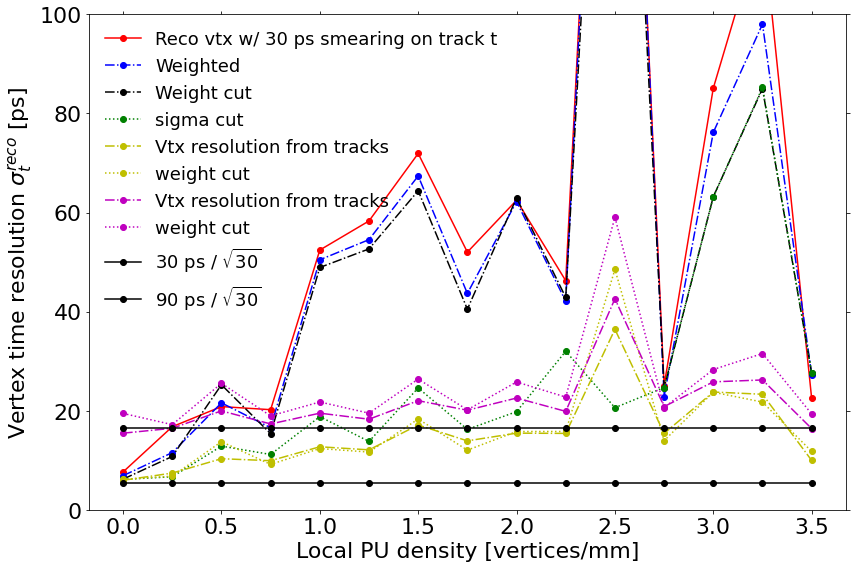

In [31]:
plt.plot(truth_bin_edges, 1e3*np.array(vtx_t30_res), 'ro-', label='Reco vtx w/ 30 ps smearing on track t')
plt.plot(truth_bin_edges, 1e3*np.array(vtx_weighted_t30_res), 'bo-.', label='Weighted')
plt.plot(truth_bin_edges, 1e3*np.array(vtx_weight_cut_t30_res), 'ko-.', label='Weight cut')
plt.plot(truth_bin_edges, 1e3*np.array(vtx_sigma_cut_weighted_t30_res), 'go:', label='sigma cut')


plt.plot(truth_bin_edges, 1e3*np.array(track_vtx_t30_res), 'yo-.', label='Vtx resolution from tracks')
plt.plot(truth_bin_edges, 1e3*np.array(track_vtx_t30_res_weight_cut), 'yo:', label='weight cut')

plt.plot(truth_bin_edges, 1e3*np.array(track_vtx_t90_res), 'mo-.', label='Vtx resolution from tracks')
plt.plot(truth_bin_edges, 1e3*np.array(track_vtx_t90_res_weight_cut), 'mo:', label='weight cut')

plt.plot(truth_bin_edges, 30/np.sqrt(30*np.ones(len(truth_bin_edges))), 'ko-', label='30 ps / $\\sqrt{30}$')
plt.plot(truth_bin_edges, 90/np.sqrt(30*np.ones(len(truth_bin_edges))), 'ko-', label='90 ps / $\\sqrt{30}$')

plt.ylim(0, 100)
plt.legend(frameon=False)
plt.xlabel('Local PU density [vertices/mm]')
plt.ylabel('Vertex time resolution $\\sigma^{reco}_t$ [ps]')
plt.tight_layout()

In [23]:
sigma_cut = 2

closest_truth_delta_t = []
closest_truth_delta_t_rms = []

closest_truth_vtx_t_res = []
closest_truth_vtx_weighted_t_res = []
closest_truth_vtx_weight_cut_t_res = []

closest_truth_vtx_t30_res = []
closest_truth_vtx_weighted_t30_res = []
closest_truth_vtx_weight_cut_t30_res = []

closest_truth_delta_t30 = []
closest_truth_delta_t30_rms = []
closest_truth_vtx_t30_res = []

closest_truth_vtx_t30_res_sigma_cut = []

events_in_PU_bins = []
for bin in truth_bin_edges:
    events_in_PU_bins.append(np.argwhere(np.isclose(truth_localPU, bin)))

avg_n_tracks = []
avg_n_tracks30 = []
avg_n_tracks30_sigma_cut = []

for event_idxs in events_in_PU_bins:
    bin_closest_truth_delta_t = np.array([])
    bin_closest_truth_delta_t_rms = []
    
    bin_closest_truth_delta_t30 = np.array([])
    bin_closest_truth_delta_t30_rms = []
    
    bin_closest_truth_vtx_delta_t = []
    bin_closest_truth_vtx_delta_t30 = []
    bin_closest_truth_vtx_weighted_delta_t = []
    bin_closest_truth_vtx_weighted_delta_t30 = []
    
    bin_closest_truth_vtx_weight_cut_delta_t = []
    bin_closest_truth_vtx_weight_cut_delta_t30 = []
    
    reco_n_tracks_events = []
    reco_n_tracks_events30 = []
    
    for idx in event_idxs:
        idx = idx[0]
        # reco_track_weights = reco_vertex_track_weights[idx][0]
        
        reco_vtx_z = reco_vertex_z[idx][0]
        truth_t = truth_vertex_t[idx][np.argmin(np.abs(truth_vertex_z[idx] - reco_vtx_z))]
        
        #Use reco HS - ie. largest sumpT2 vtx
        reco_track_t = track_t[idx][reco_vertex_track_idxs[idx][0]]
        reco_track_t_clean_idx = np.logical_and(reco_track_t != -1e3, reco_track_t != -1e6)
        reco_track_t = reco_track_t[np.logical_and(reco_track_t != -1e3, reco_track_t != -1e6)]
        
        reco_track_t30 = track_t30[idx][reco_vertex_track_idxs[idx][0]]
        reco_track_t30_clean_idx = np.logical_and(reco_track_t30 != -1e3, reco_track_t30 != -1e6)
        reco_track_t30 = reco_track_t30[reco_track_t30_clean_idx]
        
        diff_t = reco_track_t - truth_t
        diff_t30 = reco_track_t30 - truth_t
        
        reco_n_tracks_events.append(len(diff_t))
        reco_n_tracks_events30.append(len(diff_t30))
        
        bin_closest_truth_delta_t = np.concatenate((bin_closest_truth_delta_t, diff_t))
        bin_closest_truth_delta_t30 = np.concatenate((bin_closest_truth_delta_t30, diff_t30))
        
        bin_closest_truth_delta_t_rms.append(np.sqrt(np.mean(diff_t**2)))
        bin_closest_truth_delta_t30_rms.append(np.sqrt(np.mean(diff_t30**2)))
        
        
        reco_vtx_t = np.mean(reco_track_t)
        reco_vtx_t30 = np.mean(reco_track_t30)
        
        # reco_vtx_weighted_t = np.average(reco_track_t, weights=reco_track_weights[reco_track_t_clean_idx])
        # reco_vtx_weighted_t30 = np.mean(reco_track_t30, weights=reco_track_weights[reco_track_t30_clean_idx])
        
        bin_closest_truth_vtx_delta_t.append(reco_vtx_t - truth_t)
        bin_closest_truth_vtx_delta_t30.append(reco_vtx_t30 - truth_t)
        # bin_closest_truth_vtx_weighted_delta_t.append(reco_vtx_weighted_t - truth_t)
        # bin_closest_truth_vtx_weighted_delta_t30.append(reco_vtx_weighted_t30 - truth_t)
        
    
    avg_n_tracks.append(np.mean(reco_n_tracks_events))
    avg_n_tracks30.append(np.mean(reco_n_tracks_events30))
    
    closest_truth_delta_t.append(bin_closest_truth_delta_t)
    closest_truth_delta_t30.append(bin_closest_truth_delta_t30)
    
    closest_truth_delta_t_rms.append(bin_closest_truth_delta_t_rms)
    closest_truth_delta_t30_rms.append(bin_closest_truth_delta_t30_rms)
    
    closest_truth_vtx_t_res.append(np.mean(bin_closest_truth_delta_t_rms / np.sqrt(np.array(reco_n_tracks_events))))
    closest_truth_vtx_t30_res.append(np.mean(bin_closest_truth_delta_t30_rms / np.sqrt((np.array(reco_n_tracks_events30)))))
    
    bin_sigma30 = np.std(bin_closest_truth_delta_t30)
    bin_closest_truth_t30_diff_std_of_mean_sigma_cut = []
    reco_n_tracks_events_cut = []
    for idx in event_idxs:
        diff_t30_sigma_cut = diff_t30[np.abs(diff_t30 - np.mean(diff_t30)) < sigma_cut*bin_sigma30]
        reco_n_tracks_events_cut.append(len(diff_t30_sigma_cut))
        bin_closest_truth_t30_diff_std_of_mean_sigma_cut.append(np.std(diff_t30_sigma_cut)/np.sqrt(len(diff_t30_sigma_cut)))
    closest_truth_vtx_t30_res_sigma_cut.append(np.mean(bin_closest_truth_t30_diff_std_of_mean_sigma_cut))
    avg_n_tracks30_sigma_cut.append(np.mean(reco_n_tracks_events_cut))

Text(0.5, 0, 'Reco vtx track t - truth track t [ps]')

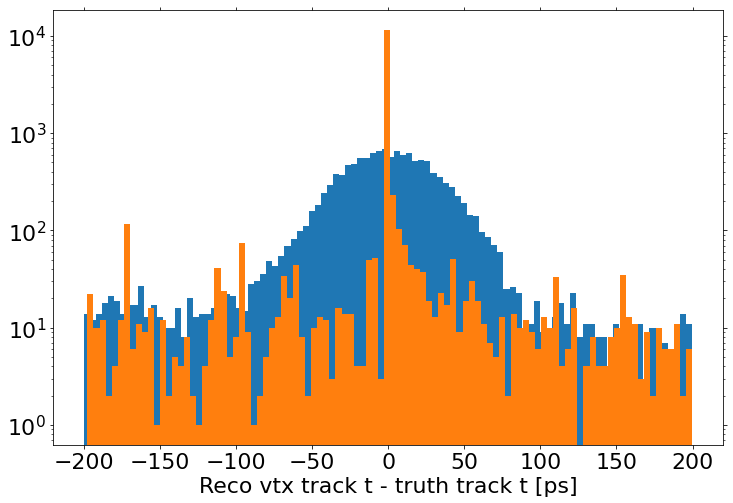

In [24]:
_ = plt.hist(1e3*np.concatenate(closest_truth_delta_t30)[np.abs(np.concatenate(closest_truth_delta_t30))<0.2], bins=100, label='No smearing')
_ = plt.hist(1e3*np.concatenate(closest_truth_delta_t)[np.abs(np.concatenate(closest_truth_delta_t))<0.2],     bins=100, label='30 ps smearing')
plt.yscale('log')
plt.xlabel('Reco vtx track t - truth track t [ps]')

Text(0, 0.5, 'Vertex time resolution $\\sigma^{reco}_t$ [ps]')

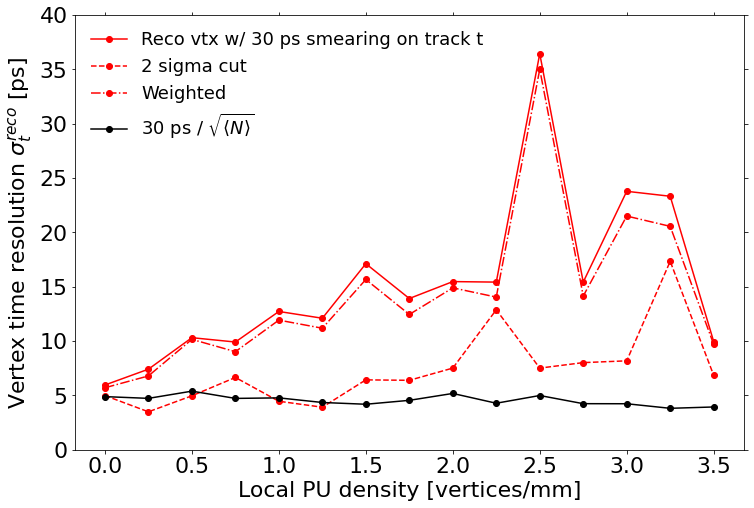

In [67]:
plt.plot(truth_bin_edges, 1e3*np.array(closest_truth_vtx_t30_res), 'ro-', label='Reco vtx w/ 30 ps smearing on track t')
plt.plot(truth_bin_edges, 1e3*np.array(closest_truth_vtx_t30_res_sigma_cut), 'ro--', label='{} sigma cut'.format(sigma_cut))
plt.plot(truth_bin_edges, 1e3*np.array(closest_truth_vtx_t30_weighted_res), 'ro-.', label='Weighted')
plt.plot(truth_bin_edges, 30/np.sqrt(avg_n_tracks), 'ko-', label='30 ps / $\\sqrt{\\langle N\\rangle}$')

plt.ylim(0, 40)
plt.legend(frameon=False)
plt.xlabel('Local PU density [vertices/mm]')
plt.ylabel('Vertex time resolution $\\sigma^{reco}_t$ [ps]')

In [ ]:
plt.plot(truth_bin_edges, 1e3*np.array(closest_truth_t30_diff_avg_std_of_mean), 'ro-', label='Reco vtx w/ 30 ps smearing on track t')
plt.plot(truth_bin_edges, 1e3*np.array(closest_truth_t30_diff_std_of_mean_sigma_cut), 'ro--', label='{} sigma cut'.format(sigma_cut))
plt.plot(truth_bin_edges, 30/np.sqrt(avg_n_tracks), 'ko-', label='30 ps / $\\sqrt{\\langle N\\rangle}$')

plt.ylim(0, 30)
plt.legend(frameon=False)
plt.xlabel('Local PU density [vertices/mm]')
plt.ylabel('Vertex time resolution $\\sigma^{reco}_t$ [ps]')

In [ ]:
def closest_truth_vtx_time_info(events_in_PU_bins, all_truth_vtx_z, all_truth_vtx_t, all_reco_track_idxs, all_reco_track_weights, all_reco_vtx_z, all_track_t, sigma_cut, weight_cut):
    track_delta_t = []
    track_delta_t_rms = []
    
    track_weight_cut_delta_t = []
    track_weight_cut_delta_t_rms = []
    
    track_vtx_t_res = []
    track_vtx_t_res_weight_cut = []
    track_vtx_t_res_sigma_cuts = []
    
    vtx_delta_t = []
    vtx_weighted_delta_t = []
    vtx_weight_cut_delta_t = []
    
    vtx_t_res = []
    vtx_weighted_t_res = []
    vtx_weight_cut_t_res = []
    vtx_weight_cut_weighted_t_res = []
    vtx_sigma_cut_weighted_t_res = []

    avg_n_tracks = []
    avg_n_tracks_weight_cut = []
    avg_n_tracks_sigma_cut = []

    for event_idxs in events_in_PU_bins:
        bin_track_delta_t = np.array([])
        bin_track_delta_t_rms = []
        
        bin_vtx_delta_t = []
        bin_vtx_weighted_delta_t = []
        
        bin_track_weight_cut_delta_t = np.array([])
        bin_track_weight_cut_delta_t_rms = []
        
        bin_vtx_weight_cut_delta_t = []
        bin_vtx_weight_cut_weighted_delta_t = []
        
        bin_reco_n_tracks = []
        bin_reco_n_tracks_weight_cut = []
        for idx in event_idxs:
            idx = idx[0]
            #Use reco HS - ie. largest sumpT2 vtx
            reco_vtx_z = all_reco_vtx_z[idx][0]
            reco_track_t = all_track_t[idx][all_reco_track_idxs[idx][0]]
            reco_track_t_clean_idx = np.logical_and(reco_track_t != -1e3, reco_track_t != -1e6)
            reco_track_t = reco_track_t[np.logical_and(reco_track_t != -1e3, reco_track_t != -1e6)]
            reco_track_weights = all_reco_track_weights[idx][0][reco_track_t_clean_idx]
            bin_reco_n_tracks.append(len(reco_track_t))
            
            truth_t = all_truth_vtx_t[idx][np.argmin(np.abs(all_truth_vtx_z[idx] - reco_vtx_z))]
            
            event_track_delta_t = reco_track_t - truth_t
            
            bin_track_delta_t = np.concatenate((bin_track_delta_t, event_track_delta_t))
            bin_track_delta_t_rms.append(np.sqrt(np.mean(event_track_delta_t**2)))
            
            reco_vtx_t = np.mean(reco_track_t)
            reco_vtx_weighted_t = np.average(reco_track_t, weights=reco_track_weights)
            
            bin_vtx_delta_t.append(reco_vtx_t - truth_t)
            bin_vtx_weighted_delta_t.append(reco_vtx_weighted_t - truth_t)
            
            # Weight cut
            weight_cut_idx = np.array(reco_track_weights) > weight_cut
            weight_cut_track_t = reco_track_t[weight_cut_idx]
            bin_reco_n_tracks_weight_cut.append(len(weight_cut_track_t))
            
            weight_cut_event_delta_t = weight_cut_track_t - truth_t
        
            bin_track_weight_cut_delta_t = np.concatenate((bin_track_weight_cut_delta_t, weight_cut_event_delta_t))
            bin_track_weight_cut_delta_t_rms.append(np.sqrt(np.mean(weight_cut_event_delta_t**2)))
            
            weight_cut_vtx_t = np.mean(weight_cut_track_t)
            weight_cut_vtx_weighted_t = np.average(weight_cut_track_t, weights = reco_track_weights[weight_cut_idx])
            
            bin_vtx_weight_cut_delta_t.append(weight_cut_vtx_t - truth_t)
            bin_vtx_weight_cut_weighted_delta_t.append(weight_cut_vtx_weighted_t - truth_t)
        
        avg_n_tracks.append(np.mean(bin_reco_n_tracks))
        avg_n_tracks_weight_cut.append(np.mean(bin_reco_n_tracks_weight_cut))
        
        track_delta_t.append(bin_track_delta_t)
        track_delta_t_rms.append(bin_track_delta_t_rms)
        track_weight_cut_delta_t.append(bin_track_weight_cut_delta_t)
        track_weight_cut_delta_t_rms.append(bin_track_weight_cut_delta_t_rms)
        track_vtx_t_res.append(np.mean(bin_track_delta_t_rms / np.sqrt(np.array(bin_reco_n_tracks))))
        track_vtx_t_res_weight_cut.append(np.mean(bin_track_weight_cut_delta_t_rms / np.sqrt(np.array(bin_reco_n_tracks_weight_cut))))
        
        
        vtx_delta_t.append(bin_vtx_delta_t)
        vtx_weighted_delta_t.append(bin_vtx_weighted_delta_t)
        vtx_weight_cut_delta_t.append(bin_vtx_weight_cut_delta_t)
        
        vtx_t_res.append(np.sqrt(np.mean(np.array(bin_vtx_delta_t)**2)))
        vtx_weighted_t_res.append(np.sqrt(np.mean(np.array(bin_vtx_weighted_delta_t)**2)))
        vtx_weight_cut_t_res.append(np.sqrt(np.mean(np.array(bin_vtx_weight_cut_delta_t)**2)))
        vtx_weight_cut_weighted_t_res.append(np.sqrt(np.mean(np.array(bin_vtx_weight_cut_weighted_delta_t)**2)))
        
        bin_vtx_weighted_delta_t_sigma = np.std(bin_vtx_weighted_delta_t, ddof=1)
        bin_vtx_delta_t_sigma_cut_idxs = np.abs(bin_vtx_weighted_delta_t - np.mean(bin_vtx_weighted_delta_t)) < sigma_cut*bin_vtx_weighted_delta_t_sigma
        vtx_sigma_cut_weighted_t_res.append(np.sqrt(np.mean(np.array(bin_vtx_weight_cut_weighted_delta_t)[bin_vtx_delta_t_sigma_cut_idxs]**2)))
        
    return  track_delta_t, \
            track_delta_t_rms, \
            track_weight_cut_delta_t, \
            track_weight_cut_delta_t_rms, \
            track_vtx_t_res, \
            track_vtx_t_res_weight_cut, \
            vtx_delta_t, \
            vtx_weight_cut_delta_t, \
            vtx_t_res, \
            vtx_weighted_t_res, \
            vtx_weight_cut_t_res, \
            vtx_weight_cut_weighted_t_res, \
            vtx_sigma_cut_weighted_t_res
            
        # bin_sigma = np.std(bin_closest_truth_delta_t)
        # bin_closest_truth_t30_diff_std_of_mean_sigma_cut = []
        # reco_n_tracks_events_cut = []
        # for idx in event_idxs:
        #     diff_t30_sigma_cut = diff_t30[np.abs(diff_t30 - np.mean(diff_t30)) < sigma_cut*bin_sigma]
        #     reco_n_tracks_events_cut.append(len(diff_t30_sigma_cut))
        #     bin_closest_truth_t30_diff_std_of_mean_sigma_cut.append(np.std(diff_t30_sigma_cut)/np.sqrt(len(diff_t30_sigma_cut)))
        # closest_truth_vtx_t30_res_sigma_cut.append(np.mean(bin_closest_truth_t30_diff_std_of_mean_sigma_cut))
        # avg_n_tracks30_sigma_cut.append(np.mean(reco_n_tracks_events_cut))